In [1]:
import zospy as zp

from tqdm import tqdm
from pylab import *
from astropy.modeling import models, fitting
import os
import pathlib
import time
import shutil

import ExtendedImagesSimulation as es
import scipy.ndimage as nd

In [2]:
zos = zp.ZOS()
oss = zos.connect("standalone")
zos.wakeup()

# Thermal sensitivity analysis

Using ZEMAX thermal capacity We analyse the position of different PSF position across the CCD of the R camera.
Taking reference a 20°C we look at the movement of the PSF with temperature.

0.001 pixel shift represent 0.75 m/s

The first analysis is done using the centroid of point source images.

Diferent fibers along the slit are simulated and compared

In [3]:
nt = 5           # nb temperature à évaluer
nw = 3           # nb wave par config définie et à évaluer
T_nom=20.        # °C Temp nominale
T_max=20.02      # °C Temp maximale
T = linspace(T_nom,T_max,nt) # définition du range temperature
mc_T = 7       # numéro ligne dans multiconfig où la temp est definie
mc_cte= 3      # numéro ligne dans multiconfig où le cte est def
mc_cte_cam=6   # numéro ligne dans multiconfig où le cte est def pour la camera
px_size = 0.010 # taille du pixel (mm)
rq_stab = 1/1000. # stab requise en px
configs = [4,5,6] #ces configurations ont la même temp, mais des ordres différents


In [4]:
oss.load("ANDES_R_v29_tel_THRML_alu.zos")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.95s/it]


Text(0.5, 1.0, 'Differential sensitivity between central fiber and outer most fiber.')

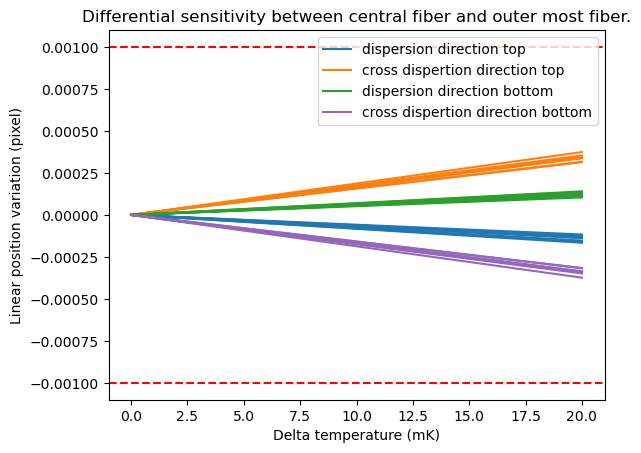

In [5]:


cte = 23. # cte de la structure du banc à évaluer
cte_cam = cte # cte de la structure du banc à évaluer


xtref = []
ytref = []
xt1 = []
yt1 = []
xt2 = []
yt2 = []



sigx = []
sigy = []
ptpx = []
ptpy = []
nc = len(configs) # nb config
ns=nw*nc

last_surface = oss.LDE.get_NumberOfSurfaces()


for c in configs:
    cte_bench = oss.MCE.GetOperandAt(mc_cte).GetCellAt(c)    
    cte_bench.Value=str(cte)
    cte_bench = oss.MCE.GetOperandAt(mc_cte).GetCellAt(c-nc)    
    cte_bench.Value=str(cte)
    cte_cam = oss.MCE.GetOperandAt(mc_cte_cam).GetCellAt(c)    
    cte_cam.Value=str(cte_cam)
    cte_cam = oss.MCE.GetOperandAt(mc_cte_cam).GetCellAt(c-nc)    
    cte_cam.Value=str(cte_cam)



for t in tqdm(T):
    for c in configs:
        for l in range(nw): # iteration sur les 3 waves
            #ln.zSetConfig(c)
            oss.MCE.SetCurrentConfiguration(c)
            temperature_sim =oss.MCE.GetOperandAt(mc_T).GetCellAt(c)
            temperature_sim.Value = str(t)
            #ln.zSetMulticon(c, mc_T, t, 0, 0, 0, 0, 0) # 2nd value=temp line in multiconf
            #ln.zPushLens()
            xbref=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 2, 0,50, 0 , 0, 0)
            ybref=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 2, 0,50, 0 , 0, 0)
            xb1=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 1, 0,50, 0 , 0, 0)
            yb1=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 1, 0,50, 0 , 0, 0)
            xb2=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 3, 0,50, 0 , 0, 0)
            yb2=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 3, 0,50, 0 , 0, 0)
            #(xb,yb,zb,intensityb) = ln.zSpiralSpot(0,0,l+1,3,10)
            #print(xb,xb)
            xtref.append(xbref) #x-centroid
            ytref.append(ybref) #y-centroid
            xt1.append(xb1) #x-centroid
            yt1.append(yb1) #y-centroid
            xt2.append(xb2) #x-centroid
            yt2.append(yb2) #y-centroid

            
            

           
    temperature_sim =oss.MCE.GetOperandAt(mc_T).GetCellAt(c)
    temperature_sim.Value = str(19.95)
    
    
    
xtref = array(xtref)
ytref = array(ytref)
xt1 = array(xt1)
yt1 = array(yt1)
xt2 = array(xt2)
yt2 = array(yt2)

figure(1)
# reshape en fct nb temp (nt),9 car 3 config x 3 wave (par config)
l1 = plot((T-T_nom)*1000,(xtref.reshape((nt,ns))-tile(xtref.reshape((nt,ns))[0,:],(nt,1)))/px_size,label="dispertion direction",c = "C0")
l2 = plot((T-T_nom)*1000,(ytref.reshape((nt,ns))-tile(ytref.reshape((nt,ns))[0,:],(nt,1)))/px_size,label="cross dispersion",c = "C1")
axhline(rq_stab,c="r",ls ="--")
axhline(-rq_stab,c="r",ls ="--")
legend((l1[0],l2[0]),("dispersion direction","cross dispertion direction"))
xlabel("Delta temperature (mK)")
ylabel("Linear position variation (pixel)")
title("Abslolute Sensitivity Aluminum Bench")





figure(2)
# reshape en fct nb temp (nt),9 car 3 config x 3 wave (par config)
l1 = plot((T-T_nom)*1000,((xtref.reshape((nt,ns))
                          -tile(xtref.reshape((nt,ns))[0,:],(nt,1)))
                          -(xt1.reshape((nt,ns))
                          -tile(xt1.reshape((nt,ns))[0,:],(nt,1))))/px_size,label="dispertion direction",c = "C0")
l2 = plot((T-T_nom)*1000,((ytref.reshape((nt,ns))-tile(ytref.reshape((nt,ns))[0,:],(nt,1)))
                          -(yt1.reshape((nt,ns))-tile(yt1.reshape((nt,ns))[0,:],(nt,1))))/px_size,label="cross dispersion",c = "C1")


l3 = plot((T-T_nom)*1000,((xtref.reshape((nt,ns))
                          -tile(xtref.reshape((nt,ns))[0,:],(nt,1)))
                          -(xt2.reshape((nt,ns))
                          -tile(xt2.reshape((nt,ns))[0,:],(nt,1))))/px_size,label="dispertion direction",c = "C2")
l4 = plot((T-T_nom)*1000,((ytref.reshape((nt,ns))-tile(ytref.reshape((nt,ns))[0,:],(nt,1)))
                          -(yt2.reshape((nt,ns))-tile(yt2.reshape((nt,ns))[0,:],(nt,1))))/px_size,label="cross dispersion",c = "C4")
axhline(rq_stab,c="r",ls ="--")
axhline(-rq_stab,c="r",ls ="--")
legend((l1[0],l2[0],l3[0],l4[0]),("dispersion direction top","cross dispertion direction top","dispersion direction bottom","cross dispertion direction bottom"))
xlabel("Delta temperature (mK)")
ylabel("Linear position variation (pixel)")
title("Differential sensitivity between central fiber and outer most fiber.")



The first graph gives the sensitivity of the spectrograph with temperature. The second one shows the error one makes correcting the movements of the PSF of the fiber on the border of the slit having measured the movement of of the central fiber. Here there are many simplifications but the main conclusion I would draw is that calibration can improve inherent stability by a factor 6.

# Comparision of the simulation methods

In the previous simulation, fibers are modeled as a point source. This is a simplification from the actual formation of a PSF. The fiber is an extended object. Here we performed the simulation using the geometrical image simulation routine from Zemax that simulate the image of extended objects. This is very time comsuming as many rays need to be sent in order to have enough signal to noise to be able to measure displacements at the right scale.

In order to be able to compare the position of the produced PSF one has to ensure they have a stable reference frame. With zemax the only actual stable reference frame for this routine is the Vertex. So in order to still have an image of the PSF at different place on the detector. I introduced a coordinate break in front of the detector and change the vertex position to be where the PSF is at the reference temperature.

In [6]:
p_vertex=[]
p_bary = []
for c in tqdm(configs):
        for l in range(nw): # iteration sur les 3 waves
            oss.MCE.SetCurrentConfiguration(c)
            temperature_sim =oss.MCE.GetOperandAt(mc_T).GetCellAt(c)
            temperature_sim.Value = str(T_nom)
            xbref=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 2, 0,5, 0 , 0, 0)
            ybref=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 2, 0,5, 0 , 0, 0)
            xb1=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 1, 0,5, 0 , 0, 0)
            yb1=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 1, 0,5, 0 , 0, 0)
            xb2=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENX,last_surface, l+1, 3, 0,5, 0 , 0, 0)
            yb2=oss.MFE.GetOperandValue(zp.constants.Editors.MFE.MeritOperandType.CENY, last_surface, l+1, 3, 0,5, 0 , 0, 0)
            ll = [xbref,ybref,xb1,yb1,xb2,yb2]
            p_vertex.append(ll)

p_vertex=array(p_vertex)





100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.37s/it]


The process then for the thermal analysis is the same as previously. I had to experiment to reduce the noise in the PSF. And I incread the number of rays to a very high number.
The simulation here below took ~ 14h on a 24 core 48 thread machine.

In [9]:
xgref = []
ygref = []
xg1 = []
yg1 = []
xg2 = []
yg2 = []
nrays = 1000000
for t in tqdm(T,position = 0):
    for i,c in enumerate(configs):
        for l in range(nw): # iteration sur les 3 waves
            #ln.zSetConfig(c)
            oss.MCE.SetCurrentConfiguration(c)
            temperature_sim =oss.MCE.GetOperandAt(mc_T).GetCellAt(c)
            temperature_sim.Value = str(t)
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_X(p_vertex[l+i*nc][0])
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_Y(p_vertex[l+i*nc][1])
            result = es.GeometricalImageAnalysis(oss,rays = nrays, field_size =0.630, image_size = 0.2, wavelength = int(l+1), reference = "Vertex",field = 2)
            bary1=nd.center_of_mass(result.Data.to_numpy())

            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_X(p_vertex[l+i*nc][2])
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_Y(p_vertex[l+i*nc][3])
            result = es.GeometricalImageAnalysis(oss,rays = nrays, field_size =0.630, image_size = 0.2, wavelength = int(l+1), reference = "Vertex",field = 1)
            bary2=nd.center_of_mass(result.Data.to_numpy())

            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_X(p_vertex[l+i*nc][4])
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_Y(p_vertex[l+i*nc][5])
            result = es.GeometricalImageAnalysis(oss,rays = nrays, field_size =0.630, image_size = 0.2, wavelength = int(l+1), reference = "Vertex",field = 3)
            bary3=nd.center_of_mass(result.Data.to_numpy())
            
            xgref.append(bary1[0])
            ygref.append(bary1[1])
            xg1.append(bary2[0])
            yg1.append(bary2[1])
            xg2.append(bary3[0])
            yg2.append(bary3[1])
            
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_X(0)
            oss.LDE.GetSurfaceAt(106).get_SurfaceData().set_Decenter_Y(0)

xgref=array(xgref)
ygref=array(ygref)
xg1=array(xg1)
yg1=array(yg1)
xg2=array(xg2)
yg2=array(yg2)

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [13:37:27<00:00, 9809.57s/it]


X and Y are inversed with respect to the previous simulation.

Text(0.5, 1.0, 'Abslolute Sensitivity Aluminum Bench')

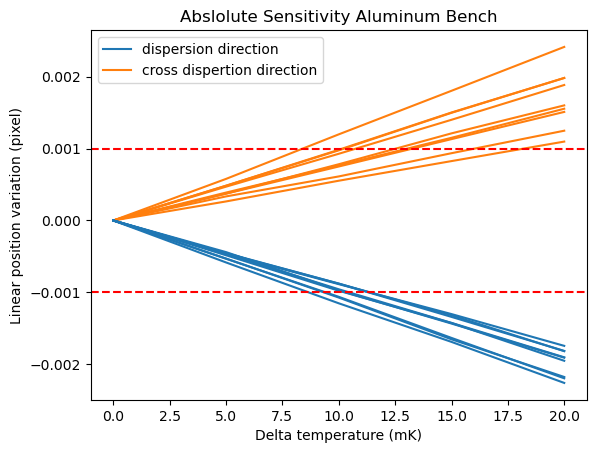

In [19]:
figure(1)
# reshape en fct nb temp (nt),9 car 3 config x 3 wave (par config)
l2 = plot((T-T_nom)*1000,(xgref.reshape((nt,ns))-tile(xgref.reshape((nt,ns))[0,:],(nt,1)))*0.2/100/px_size,label="cross dispertion",c = "C1")
l1 = plot((T-T_nom)*1000,(ygref.reshape((nt,ns))-tile(ygref.reshape((nt,ns))[0,:],(nt,1)))*0.2/100/px_size,label="dispersion direction",c = "C0")
axhline(rq_stab,c="r",ls ="--")
axhline(-rq_stab,c="r",ls ="--")
legend((l1[0],l2[0]),("dispersion direction","cross dispertion direction"))
xlabel("Delta temperature (mK)")
ylabel("Linear position variation (pixel)")
title("Abslolute Sensitivity Aluminum Bench")


In [18]:
figure(2)
# reshape en fct nb temp (nt),9 car 3 config x 3 wave (par config)
l2 = plot((T-T_nom)*1000,((xgref.reshape((nt,ns))
                          -tile(xgref.reshape((nt,ns))[0,:],(nt,1)))
                          -(xg1.reshape((nt,ns))
                          -tile(xg1.reshape((nt,ns))[0,:],(nt,1))))*0.2/100/px_size,label="cross dispertion",c = "C1")
l1 = plot((T-T_nom)*1000,((ygref.reshape((nt,ns))-tile(ygref.reshape((nt,ns))[0,:],(nt,1)))
                          -(yg1.reshape((nt,ns))-tile(yg1.reshape((nt,ns))[0,:],(nt,1))))*0.2/100/px_size,label="dispersion direction",c = "C0")


l4 = plot((T-T_nom)*1000,((xgref.reshape((nt,ns))
                          -tile(xgref.reshape((nt,ns))[0,:],(nt,1)))
                          -(xg2.reshape((nt,ns))
                          -tile(xg2.reshape((nt,ns))[0,:],(nt,1))))*0.2/100/px_size,label="cross dispertion",c = "C4")
l3 = plot((T-T_nom)*1000,((ygref.reshape((nt,ns))-tile(ygref.reshape((nt,ns))[0,:],(nt,1)))
                          -(yg2.reshape((nt,ns))-tile(yg2.reshape((nt,ns))[0,:],(nt,1))))*0.2/100/px_size,label="dispersion direction",c = "C2")
axhline(rq_stab,c="r",ls ="--")
axhline(-rq_stab,c="r",ls ="--")
legend((l1[0],l2[0],l3[0],l4[0]),("dispersion direction top","cross dispertion direction top","dispersion direction bottom","cross dispertion direction bottom"))
xlabel("Delta temperature (mK)")
ylabel("Linear position variation (pixel)")
title("Differential sensitivity between central fiber and outer most fiber.")

Text(0.5, 1.0, 'Differential sensitivity between central fiber and outer most fiber.')

At first glance the result seem pretty similar. Lets compare things point to point

In [17]:
figure(1)
# reshape en fct nb temp (nt),9 car 3 config x 3 wave (par config)
l2 = plot((T-T_nom)*1000,(xgref.reshape((nt,ns))-tile(xgref.reshape((nt,ns))[0,:],(nt,1)))*0.2/100/px_size-(ytref.reshape((nt,ns))-tile(ytref.reshape((nt,ns))[0,:],(nt,1)))/px_size,label="dispertion direction",c = "C1")
l1 = plot((T-T_nom)*1000,(ygref.reshape((nt,ns))-tile(ygref.reshape((nt,ns))[0,:],(nt,1)))*0.2/100/px_size-(xtref.reshape((nt,ns))-tile(xtref.reshape((nt,ns))[0,:],(nt,1)))/px_size,label="dispersion direction",c = "C0")
axhline(rq_stab,c="r",ls ="--")
axhline(-rq_stab,c="r",ls ="--")
legend((l1[0],l2[0]),("dispersion direction","cross dispertion direction"))
xlabel("Delta temperature (mK)")
ylabel("Linear position variation (pixel)")
title("Abslolute Sensitivity Aluminum Bench")

Text(0.5, 1.0, 'Abslolute Sensitivity Aluminum Bench')

If one make the point to point difference only the noise of teh simulation reamins thus at least for this kind of very low deformation regime it seems that the simple point source centroid is good enough to trace the actual movement of the PSF.